# Multi-Criteria Routing

**Authors:** Yalun Luan, Dongfang Cui, Lanfang Zhang and Junyuan Chen<br>
**Course:** ECE1724H: Bio-inspired Algorithms for Smart Mobility - Fall 2021<br>
**Instructor:** Dr. Alaa Khamis<br>
**Department:** Edward S. Rogers Sr. Department of Electrical & Computer Engineering, University of Toronto

## Introduction

As opposed to the traditional "shortest path" route optimization problem, multi-criteria routing considers other factors in route planning, such as:

- number of intersections
- arrival/departure time gap
- danger zones
- number of left turns
- road capacity
- traffic scheduling estimation, etc.

These factors can be combined with other vehicular routing problems, such as capacitated vehicle routing problems (CVRP), vehicle routing problem with profits (VRPP) etc.<br>
This example case will consider two factors, in addition to shortest path: red light intersections, and intersections with a history of fatal collisions.

In [1]:
import osmnx
import pandas as pd
from smart_mobility_utilities.common import Node
from collections import *
from collections import *
import numpy as np
from pymoo.core.problem import Problem
import random
from smart_mobility_utilities.common import cost
import numpy as np
from pymoo.core.duplicate import ElementwiseDuplicateElimination
from pymoo.core.mutation import Mutation
from pymoo.core.sampling import Sampling
from pymoo.core.crossover import Crossover
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from matplotlib import pyplot as plt
import osmnx
import pandas as pd
import matplotlib.pyplot as plt
from smart_mobility_utilities.common import Node
from smart_mobility_utilities.viz import draw_route
from smart_mobility_utilities.viz import draw_map
from smart_mobility_utilities.common import randomized_search, cost, probability
from smart_mobility_utilities.children import get_children
from tqdm.notebook import tqdm
import random
import tabulate
import itertools
import timeit

## Dataset

This example considers the area surrounding the University of Toronto's St. George campus in Downtown Toronto. A list of 567 intersections are labelled with a boolean value marking whether or not a fatal collision has occured there in the past.

In [2]:
df = pd.read_csv("collision_with_osmnxId.csv")
df.head(10)

,Unnamed: 0,LATITUDE,LONGITUDE,Collision,osmnxId
0,0,43.649418,-79.371446,0,4095622247
1,1,43.650461,-79.371924,0,25768773
2,2,43.651534,-79.372360,0,29687658
3,3,43.652718,-79.372824,0,29687912
4,4,43.653704,-79.373238,0,29688544
5,5,43.655357,-79.373862,0,29688418
6,6,43.657052,-79.374531,1,25768772
7,7,43.660432,-79.375854,0,29603394
8,8,43.662420,-79.376708,1,27571559
9,9,43.666289,-79.378325,1,25628755


This can be further split into two lists; one containing all intersections, and another with the collisions only.

In [3]:
intersectionData = df.osmnxId.to_list()
collisionData = df.loc[df["Collision"]==1].osmnxId.to_list()

## Problem Formulation

### Variables
$n$ is the number of nodes in a given route<br>
$l_i$ is the length of a road segment from node $i$ to node $i+1$.<br>
$r_i$ is a boolean value (0 or 1) representing whether a node is also an intersection with a red light<br>
$s_i$ is the speed, in km/h of the road segment between nodes $i$ and $i+1$<br>
$f_i$ is a boolean value (0 or 1) representing whether or not an intersection has had a fatal collision in the past<br>
$X$ represents an "average" wait time at a red light<br>
$Y$ represents an "average" penalty issued for passing through a "dangerous" red light (i.e. has a history of fatal collisions)

### Objective
$\sum_{i=0}^{n-1} l_i + r_i(s_iX/3.6) + f_iY$

Essentially, the score of a given route is the sum of the lengths of the edges in the route, with penalties added for:
1. Passing through an intersection
2. Passing through an intersection that is considered "dangerous"


## Problem Setup

For this example, we will assume that a route is sought between the following nodes:

In [4]:
bbox=[43.647281, 43.669197, -79.411827, -79.374476]
G=osmnx.graph_from_bbox(*bbox, network_type='drive_service')
origin = Node(G, 82759481)
destination = Node(G, 29605000)

Both simulated annealing and a Non-dominated Sorting Genetic Algorithm (NSGA-II) will be tested.

## Simulated Annealing
The following schedule will be used for Simulated Annealing:

In [5]:
def exp_schedule(k=20, lam=0.005, limit=100):
    function = lambda t: (k * np.exp(-lam*t) if t < limit else 0)
    return function

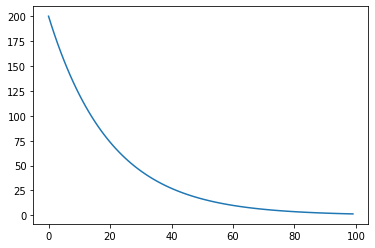

In [6]:
schedule = exp_schedule(200,0.05,10000)
T = [schedule(k) for k in range(100)]
plt.plot(T)

### Solution Class

In [7]:
def cost(G, route):
    weight = 0
    for u,v in zip(route, route[1:]):
        weight += G[u][v][0]['length']
    return round(weight,4)
    
def weightedCost(G, route,weight1,weight2):
    weight = 0
    for u, v in zip(route, route[1:]):
        weight += G[u][v][0]['length']
        if str(v) in intersectionData:
          weight += weight1
        if str(v) in collisionData:
          weight += weight2
    return round(weight,4)


def distanceCost(G, route):
    weight = 0
    for u, v in zip(route, route[1:]):
        weight += G[u][v][0]['length']
    return round(weight,4)

def intersectionCost(G, route):
    weight = 0
    for u, v in zip(route, route[1:]):
        if v in intersectionData:
          weight += 1
    return weight

def collisionCost(G, route):
    weight = 0
    for u, v in zip(route, route[1:]):
        if v in collisionData:
          weight += 1
    return weight

def SA(temperature, num_iterations, weight1, weight2):
    schedule = exp_schedule(temperature,0.05,10000)

    states = []
    current = randomized_search(G, origin.osmid, destination.osmid)

    for t in tqdm(range(num_iterations)):
        #exponetially decreasing temperature
        T = schedule(t)
        #saved for later cost-epoch graph
        states.append(weightedCost(G,current,weight1, weight2))

        # Generate more paths to choose from
        neighbours = get_children(G,current,num_children=5)
        next_choice = random.choice(neighbours)

        delta_e = weightedCost(G,next_choice,weight1, weight2) - weightedCost(G,current,weight1, weight2)
        if delta_e <0 or probability(np.exp(-1 * delta_e/T)):
            current = next_choice

    route = current
    return route, states

def adaptiveSA(temperature, num_iterations, weight1, weight2):
    schedule = exp_schedule(temperature,0.05,10000)

    states = []
    current = randomized_search(G, origin.osmid, destination.osmid)

    for t in tqdm(range(num_iterations)):
        #exponetially decreasing temperature
        T = schedule(t)
        #generate uniform random variable in [0,1]
        acceptance_P = random.uniform(0,1)
        #saved for later cost-epoch graph
        states.append(weightedCost(G,current,weight1, weight2))
        
        # Generate more paths to choose from
        neighbours = get_children(G,current,num_children=5)
        next_choice = random.choice(neighbours)
      
        delta_e = weightedCost(G,next_choice,weight1, weight2) - weightedCost(G,current,weight1, weight2)
        if delta_e <0 or probability(np.exp(-1 * delta_e/T)) > acceptance_P:
            current = next_choice

    route = current
    return route, states

def singleSA(temperature, num_iterations, weight1, weight2):
    schedule = exp_schedule(temperature,0.05,10000)

    states = []
    current = randomized_search(G, origin.osmid, destination.osmid)

    for t in tqdm(range(num_iterations)):
        #exponetially decreasing temperature
        T = schedule(t)
        #saved for later cost-epoch graph
        states.append(cost(G,current))

        # Generate more paths to choose from
        neighbours = get_children(G,current,num_children=5)
        next_choice = random.choice(neighbours)

        delta_e = cost(G,next_choice) - cost(G,current)
        if delta_e <0 or probability(np.exp(-1 * delta_e/T)):
            current = next_choice

    route = current
    return route, states

def getResult(resultRoute):
    result = {
        "len": len(resultRoute),
        "route": resultRoute,
        "distance": distanceCost(G,resultRoute),
        "intersections": intersectionCost(G,resultRoute),
        "collisions": collisionCost(G,resultRoute)
    }
    return result
    
def printResult(resultRoute):
    print(len(resultRoute))
    print(resultRoute)
    print("distance: ", distanceCost(G, resultRoute))
    print("intersections: ", intersectionCost(G, resultRoute))
    print("collisions: ", collisionCost(G, resultRoute))

def printStates(resultStates):
    minValue = float('inf')
    minIndex = -1
    for i,v in enumerate(resultStates):
      if v < minValue:
        minValue = v
        minIndex = i
    
    print("convergence iteration number: ", minIndex)

    plt.xlabel("# iterations")
    plt.ylabel("Weighted Cost (meters)")
    plt.plot(resultStates)
    plt.show()

### Experiment #1: Varying starting temperature

As can be seen below, higher start temperatures produce longer convergence times. Lower starting temperatures tend to produce better results in terms of optimality, but temperatures that are too low will get stuck at a local minimum.

In [8]:
temperature = 225
num_iterations = 80
weight1 = 50
weight2 = 200
route1,states1 = SA(temperature, num_iterations, weight1, weight2)

  0%|          | 0/80 [00:00<?, ?it/s]

In [35]:
temperature = 175
route2,states2 = SA(temperature, num_iterations, weight1, weight2)

  0%|          | 0/80 [00:00<?, ?it/s]

In [36]:
temperature = 125
route3,states3 = SA(temperature, num_iterations, weight1, weight2)

  0%|          | 0/80 [00:00<?, ?it/s]

In [37]:
temperature = 75
route4,states4 = SA(temperature, num_iterations, weight1, weight2)

  0%|          | 0/80 [00:00<?, ?it/s]

In [ ]:
route1 = getResult(route1)
route2 = getResult(route2)
route3 = getResult(route3)
route4 = getResult(route4)

In [63]:
headers = ['starting_temp'] + list(route1.keys())
t1 = [225] + list(route1.values())
t2 = [175] + list(route2.values())
t3 = [125] + list(route3.values())
t4 = [75] + list(route4.values())
table = [headers,t1,t2,t3,t4]
routes = [x[2] for x in table[1:]]
table = [[x[0]]+x[3:] for x in table]
print(tabulate.tabulate(table, tablefmt='fancy_grid'))


╒═══════════════╤══════════╤═══════════════╤════════════╕
│ starting_temp │ distance │ intersections │ collisions │
├───────────────┼──────────┼───────────────┼────────────┤
│ 225           │ 1690.19  │ 4             │ 0          │
├───────────────┼──────────┼───────────────┼────────────┤
│ 175           │ 1919.545 │ 3             │ 0          │
├───────────────┼──────────┼───────────────┼────────────┤
│ 125           │ 1686.716 │ 4             │ 0          │
├───────────────┼──────────┼───────────────┼────────────┤
│ 75            │ 1914.135 │ 4             │ 0          │
╘═══════════════╧══════════╧═══════════════╧════════════╛


In [69]:
route_map = osmnx.plot_route_folium(G,routes[0], color="green",opacity="0.5")
route_map = osmnx.plot_route_folium(G,routes[1], route_map = route_map, color="blue",opacity="0.5")
route_map = osmnx.plot_route_folium(G,routes[2], route_map = route_map, color="orange",opacity="0.5")
route_map = osmnx.plot_route_folium(G,routes[3], route_map = route_map, color="purple",opacity="0.5")
route_map

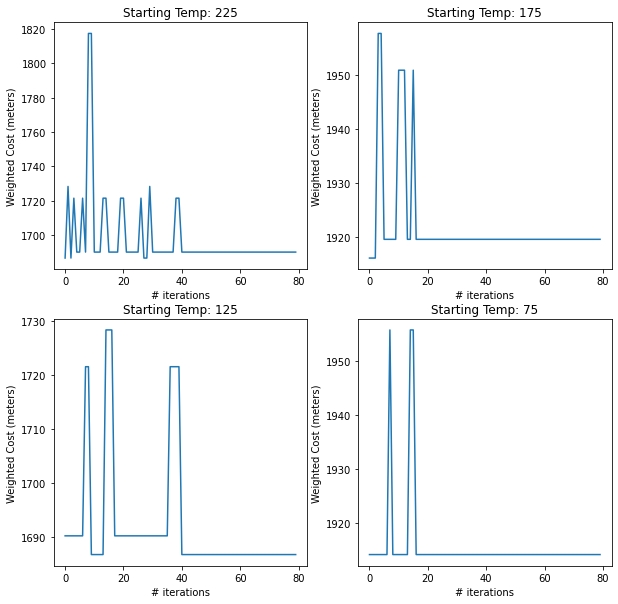

In [77]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(10)
axs[0,0].plot(states1)
axs[0,0].title.set_text("Starting Temp: 225")
axs[0,1].plot(states2)
axs[0,1].title.set_text("Starting Temp: 175")
axs[1,0].plot(states3)
axs[1,0].title.set_text("Starting Temp: 125")
axs[1,1].plot(states4)
axs[1,1].title.set_text("Starting Temp: 75")
for ax in axs.flat:
    ax.set(xlabel='# iterations', ylabel="Weighted Cost (meters)")


### Experiment #2: Varying starting temperature with Adaptive SA

The same experiment can be performed using an adaptive version of the previous algorithm. This adaptive version holds higher temperatures for a longer time through the use of an "acceptance" distribution.

In [79]:
temperature = 225
route5,states5 = adaptiveSA(temperature, num_iterations, weight1, weight2)

  0%|          | 0/80 [00:00<?, ?it/s]

In [80]:
temperature = 175
route6,states6 = adaptiveSA(temperature, num_iterations, weight1, weight2)

  0%|          | 0/80 [00:00<?, ?it/s]

In [81]:
temperature = 125
route7,states7 = adaptiveSA(temperature, num_iterations, weight1, weight2)

  0%|          | 0/80 [00:00<?, ?it/s]

In [82]:
temperature = 75
route8,states8 = adaptiveSA(temperature, num_iterations, weight1, weight2)

  0%|          | 0/80 [00:00<?, ?it/s]

In [83]:
route5 = getResult(route5)
route6 = getResult(route6)
route7 = getResult(route7)
route8 = getResult(route8)

In [84]:
t5 = [225] + list(route5.values())
t6 = [175] + list(route6.values())
t7 = [125] + list(route7.values())
t8 = [75] + list(route8.values())
table2 = [headers,t5,t6,t7,t8]
routes2 = [x[2] for x in table2[1:]]
table2 = [[x[0]]+x[3:] for x in table2]
print(tabulate.tabulate(table2, tablefmt='fancy_grid'))

╒═══════════════╤══════════╤═══════════════╤════════════╕
│ starting_temp │ distance │ intersections │ collisions │
├───────────────┼──────────┼───────────────┼────────────┤
│ 225           │ 1919.76  │ 3             │ 0          │
├───────────────┼──────────┼───────────────┼────────────┤
│ 175           │ 1916.071 │ 3             │ 0          │
├───────────────┼──────────┼───────────────┼────────────┤
│ 125           │ 1919.545 │ 3             │ 0          │
├───────────────┼──────────┼───────────────┼────────────┤
│ 75            │ 1854.955 │ 4             │ 0          │
╘═══════════════╧══════════╧═══════════════╧════════════╛


In [86]:
route_map = osmnx.plot_route_folium(G,routes2[0], color="green",opacity="0.5")
route_map = osmnx.plot_route_folium(G,routes2[1], route_map = route_map, color="blue",opacity="0.5")
route_map = osmnx.plot_route_folium(G,routes2[2], route_map = route_map, color="orange",opacity="0.5")
route_map = osmnx.plot_route_folium(G,routes2[3], route_map = route_map, color="purple",opacity="0.5")
route_map

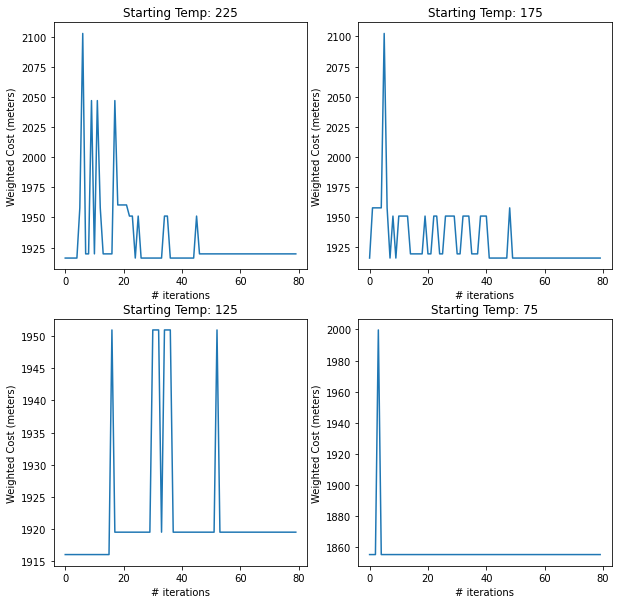

In [87]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(10)
axs[0,0].plot(states5)
axs[0,0].title.set_text("Starting Temp: 225")
axs[0,1].plot(states6)
axs[0,1].title.set_text("Starting Temp: 175")
axs[1,0].plot(states7)
axs[1,0].title.set_text("Starting Temp: 125")
axs[1,1].plot(states8)
axs[1,1].title.set_text("Starting Temp: 75")
for ax in axs.flat:
    ax.set(xlabel='# iterations', ylabel="Weighted Cost (meters)")

## NSGA-II

Here is an example solution for this problem implemented using NSGA-II and PyMoo. You can read more about this algorithm [here](https://pymoo.org/algorithms/moo/nsga2.html).

### Solution Class

In [110]:
def cross_over(route_1, route_2):
    origin = route_1[0]
    destination = route_1[-1]
    intersection = [*itertools.filterfalse(\
                    lambda element : element in [origin, destination] ,\
                    list(set(route_1) & set(route_2)))]

    if len(intersection) == 0: 
      return route_1, route_2 # if there is not common node, just return the first route

    cross_over_point = random.choice(intersection)
    first_point = route_1.index(cross_over_point)
    second_point = route_2.index(cross_over_point)

    res_1 = route_1[:first_point] + route_2[second_point:]
    res_2 = route_2[:second_point] + route_1[first_point:]

    return res_1, res_2

def dijkstra(G, origin, destination):

    # Using a set here avoids the problem with self loops
    seen = set()
    shortest_dist = {osmid: math.inf for osmid in G.nodes()}
    unrelaxed_nodes = [Node(graph = G, osmid = osmid) for osmid in G.nodes()]

    shortest_dist[origin] = 0
    found = False

    while len(unrelaxed_nodes) > 0 and not found:
    
        node = min(unrelaxed_nodes, key = lambda node : shortest_dist[node.osmid])
        
        # relaxing the node
        unrelaxed_nodes.remove(node)
        seen.add(node.osmid)
            
        # if the destination node has been relaxed then that is the route we want
        if node == destination:
            route = node.path()
            found = True
            continue
        
        # otherwise, let's relax edges of its neighbours
        for child in node.expand():
            # skip self-loops
            
            if child.osmid in seen: continue
            
            child_obj = next((node for node in unrelaxed_nodes if node.osmid == child.osmid), None)
            child_obj.distance = child.distance
            
            distance = shortest_dist[node.osmid] + child.distance
            if distance < shortest_dist[child_obj.osmid]:
                shortest_dist[child_obj.osmid] = distance
                child_obj.parent = node
            
    return route

def mutate(route, G):
    source = route[0]
    destination = route[-1]

    path = route.copy()
    size = len(route)
    for i in range(1, size):
      end = random.randint(i+1,size-2)
      #subpath = dijkstra(G, route[i-1], route[end+1])
      #subpath = osmnx.distance.shortest_path(G, route[i-1], route[end+1])
      subpath = randomized_search(G, route[i-1], route[end+1])
      newPath = route[:i-1]+subpath+route[end+2:]
      if len(newPath) == len(set(newPath)):
        return newPath

    return path

class NSGA_II(Problem):

    def __init__(self, n_characters=10):
        super().__init__(n_var=1, n_obj=3, n_constr=0)
        self.state = []
        self.G = self.generateMap()
        self.df =  df
        self.ids = self.df['osmnxId'].tolist()
        self.source = 82759481
        self.destination = 29605000
    
    def generateMap(self): 
        bbox=[43.647281, 43.669197, -79.411827, -79.374476]
        return osmnx.graph_from_bbox(*bbox, network_type='drive_service')

    def calculateDistance(self, G,route):
        return cost(G, route)

    def calculateSafety(self, df, route, ids):
        safety = 0
        for i in range(len(route)):
          if route[i] in ids:
            if df.loc[df['osmnxId'] == route[i], 'Collision'].iloc[0] > 0:
              safety += 1000
        return safety

    def calculateIntersections(self, df, route, ids):
        intersection = 0
        for i in range(len(route)):
          if route[i] in ids:
            intersection += 1000
        return intersection

    def _evaluate(self, X, out, *args, **kwargs):
        costs = []
        for x in X:
          costs.append(self.calculateDistance(self.G, x[0]))
        safety_list = []
        for x in X:
          safety_list.append(self.calculateSafety(self.df, x[0], self.ids))
        intersections = []
        for x in X:
          intersections.append(self.calculateIntersections(self.df, x[0], self.ids))
        out["F"] = np.column_stack([costs, safety_list, intersections])
        self.state.append(out["F"])
        #out["F"] = np.array([- n_a, - n_b], dtype=float)

from pymoo.core.sampling import Sampling

class MySampling1(Sampling):

    def _do(self, problem, n_samples, **kwargs):
        #X = np.full((n_samples, 1), None, dtype=object)
        X = []
        for i in range(n_samples):
            X.append([randomized_search(problem.G, problem.source, problem.destination)])
            #X[i, 0] = randomized_search(problem.G, problem.source, problem.destination)#"".join([np.random.choice(problem.ALPHABET) for _ in range(problem.n_characters)])
        return X
from pymoo.core.crossover import Crossover

class MyCrossover1(Crossover):
    def __init__(self, prob=0.7):

        # define the crossover: number of parents and number of offsprings
        super().__init__(2, 2)
        self.prob = prob

    def _do(self, problem, X, **kwargs):

        # The input of has the following shape (n_parents, n_matings, n_var)
        _, n_matings, n_var = X.shape
        # The output owith the shape (n_offsprings, n_matings, n_var)
        # Because there the number of parents and offsprings are equal it keeps the shape of X
        Y = np.full_like(X, None, dtype=object)
        if np.random.uniform(0, 1) < self.prob:
            return X
        # for each mating provided
        for k in range(n_matings):
            # get the first and the second parent
            a, b = X[0, k, 0], X[1, k, 0]
            # prepare the offsprings
            if a == b and np.random.uniform(0, 1) < 0.1:
                off_a = a
                off_b = randomized_search(problem.G, a[0], a[-1])
            else:
                off_a, off_b = cross_over(a,b)
            
            Y[0, k, 0], Y[1, k, 0] = off_a, off_b
        return Y
from pymoo.core.mutation import Mutation

class MyMutation1(Mutation):
    def __init__(self, prob =0.4):
        super().__init__()
        self.prob  = prob 

    def _do(self, problem, X, **kwargs):
        offspring=[]
        # loop over individuals in population
        for i in X:
            # performe mutation with certain probability
            if np.random.uniform(0, 1) < self.prob:
                mutated_individual = mutate(i[0], problem.G)
                offspring.append([mutated_individual])
        # if no mutation
            else:
                offspring.append([i[0]])
        #for i in range(len(X)):
        #    r = np.random.random()

            # with a probabilty of 40% - change the order of characters
         #   if r < self.prob:
         #       mutated_individual = mutate(X[i][0], problem.G)
         #       offspring.append([mutated_individual])
            # also with a probabilty of 40% - change a character randomly
            #elif:
                #offspring.append([X[i]])

        return offspring
from pymoo.core.duplicate import ElementwiseDuplicateElimination

class MyDuplicateElimination1(ElementwiseDuplicateElimination):

    def is_equal(self, a, b):
        return a.X[0] == b.X[0]

### Parameters

In [111]:
pop_size = 20
n_offSpring = 10
n_gen = 200
mutation_prob = 0.4
crossover_prob = 1.0

### Experiment #3: Solution using NSGA-II

In [112]:
problem = NSGA_II()
random.seed(10)
start = timeit.default_timer()
algorithm = NSGA2(pop_size=pop_size,
                  sampling=MySampling1(),
                  crossover=MyCrossover1(),
                  n_offspring = n_offSpring,
                  mutation=MyMutation1(),
                  eliminate_duplicates=False)
from pymoo.factory import get_termination
termination = get_termination("n_gen", n_gen)

res = minimize(problem,
               algorithm,
               termination,
               save_history=True, 
               verbose=True)
stop = timeit.default_timer()


/home/yinan/book-env/lib/python3.8/site-packages/pymoo/core/population.py:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = [np.array(e) for e in res]


n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      20 |       3 |            - |            -
    2 |      40 |       2 |  0.021388879 |        nadir
    3 |      60 |       5 |  0.00000E+00 |            f
    4 |      80 |      10 |  0.00000E+00 |            f
    5 |     100 |      14 |  0.011124519 |        nadir
    6 |     120 |      20 |  0.00000E+00 |            f
    7 |     140 |      20 |  0.00000E+00 |            f
    8 |     160 |      20 |  0.00000E+00 |            f
    9 |     180 |      20 |  0.00000E+00 |            f
   10 |     200 |      20 |  0.290131115 |        nadir
   11 |     220 |      20 |  0.00000E+00 |            f
   12 |     240 |      20 |  0.00000E+00 |            f
   13 |     260 |      20 |  0.00000E+00 |            f
   14 |     280 |      20 |  0.00000E+00 |            f
   15 |     300 |      20 |  0.00000E+00 |            f
   16 |     320 |      20 |  0.00000E+00 |            f
   17 |     340 |      20 |  0.00000E+00 |      

### Visualizing the Results

Time:  32.134220652000295
final score:  1132.932
distance:  1665.864
collisions:  0.0
intersections:  1.0
convergence iteration number:  9


/home/yinan/book-env/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


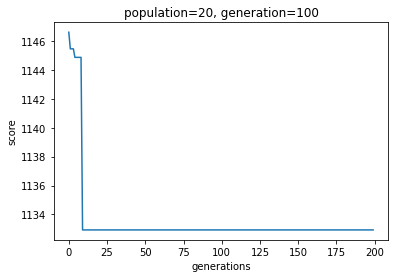

In [113]:
print('Time: ', stop - start) 

f = []
# iterate over the generations
for generation in res.history:
 # retrieve the optimal for all objectives from the generation
 opt = generation.opt
 this_f = opt.get("F")
 f.append(this_f)

fNumpy = np.asarray(f)
history = fNumpy

weights = [0.5,0.2,0.3]
mins = []
converg_iter = n_gen
for generation in fNumpy:
  min_score = 100000000000
  for f in generation:
    #print(f[0])
    score = weights[0]*f[0]+weights[1]*f[1]+weights[2]*f[2]
    min_score = min(score, min_score)
  mins.append(min_score)
min_score = mins[-1]
for i in range(len(mins)-1,0, -1):
  if(mins[i] == min_score):
    converg_iter -= 1

plt.plot(mins)
plt.xlabel("generations")
plt.ylabel("score")
plt.title("population=20, generation=100")

decisions = []
for f in res.F:
  score = weights[0]*f[0]+weights[1]*f[1]+weights[2]*f[2]
  decisions.append(score)
val, idx = min((val, idx) for (idx, val) in enumerate(decisions))
print("final score: ", val)
print("distance: ", res.F[idx][0])
print("collisions: ", res.F[idx][1]/1000)
print("intersections: ", res.F[idx][2]/1000)
print("convergence iteration number: ", converg_iter)

In [156]:
X=res.X
pool = []
for element in X:
  pool.append(element[0])

random_hexa = lambda: random.randint(0,255) # generate random hexadecimal color
rc = ['#%02X%02X%02X' % (random_hexa(),random_hexa(),random_hexa()) for _ in range(len(pool))]
route_map = osmnx.plot_route_folium(G,pool.pop(), color=rc.pop(), opacity=0.5)
for x in pool:
    route_map = osmnx.plot_route_folium(G,x, opacity=0.5, color=rc.pop(), route_map=route_map) 
route_map


The NSGA-II algorithm generates a set of solutions, depending on the balance between the various constraints.

We can define a custom weighting of the constraints to select a solution. Below you can see the differences in solutions when different weights are used:

In [152]:
def getRouteByWeight(weights):
  decisions = []
  for f in res.F:
    score = weights[0]*f[0]+weights[1]*f[1]+weights[2]*f[2]
    decisions.append(score)
  val, idx = min((val, idx) for (idx, val) in enumerate(decisions))
  print("final score: ", val)
  print("distance: ", res.F[idx][0])
  print("collision: ", res.F[idx][1])
  print("intersections: ", res.F[idx][2]/1000)
  return res.X[idx][0]

In [155]:
# Test Weight 1
weight1 = [0.5,0.2,0.3]
test1 = getRouteByWeight(weight1)
print("---")

# Shortest Path
weight2 = [1.0,0.0,0.0]
test2 = getRouteByWeight(weight2)
print("---")

final score:  1132.932
distance:  1665.864
collision:  0.0
intersections:  1.0
---
final score:  1544.078
distance:  1544.078
collision:  0.0
intersections:  3.0
---


In [157]:
route_map = osmnx.plot_route_folium(G,test1, color='green', opacity=0.5)
route_map = osmnx.plot_route_folium(G,test2, color='red', route_map=route_map,opacity=0.5) 
route_map